In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# File path to your data (change if needed)
file_path = "55Cnc_rv_data.txt"

# Skip metadata lines and read data from the first row that starts with a digit
with open(file_path, 'r') as f:
    lines = f.readlines()

# Extract only the rows that start with a number (data rows)
data_lines = [line for line in lines if line.strip() and line.strip()[0].isdigit()]

# Parse the data into columns: time, RV, uncertainty
from io import StringIO

data_str = "".join(data_lines)
df = pd.read_csv(StringIO(data_str), delim_whitespace=True, header=None)
df.columns = ["time", "rv", "uncertainty"]

# Preview the result
df.head()

/var/folders/yj/bc3_3rwj1nv5m8tw0bh6xhh00000gn/T/ipykernel_31852/4131896930.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO(data_str), delim_whitespace=True, header=None)


,time,rv,uncertainty
0,2.449676e+06,131.910004,4.84
1,2.449768e+06,22.600000,2.57
2,2.449769e+06,-5.490000,2.68
3,2.449794e+06,107.309998,1.52
4,2.450057e+06,116.669998,1.62


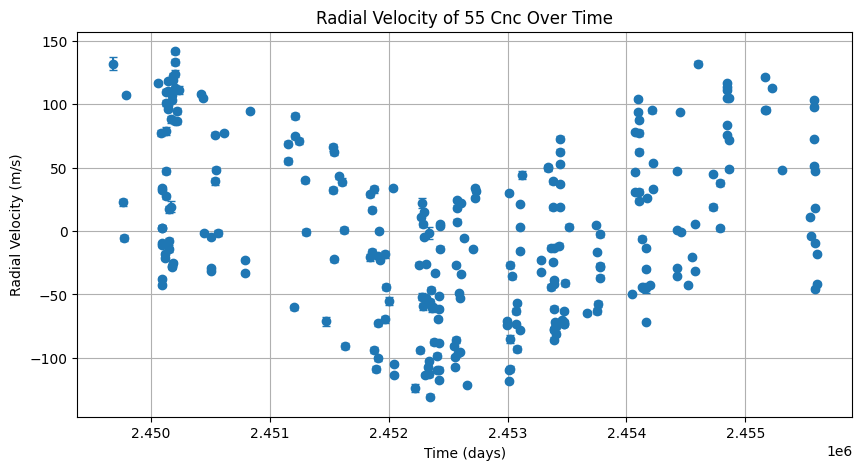

In [2]:
plt.figure(figsize=(10, 5))
plt.errorbar(df["time"], df["rv"], yerr=df["uncertainty"], fmt='o', capsize=3)
plt.title("Radial Velocity of 55 Cnc Over Time")
plt.xlabel("Time (days)")
plt.ylabel("Radial Velocity (m/s)")
plt.grid(True)
plt.savefig("rv_data_plot.pdf")
plt.show()

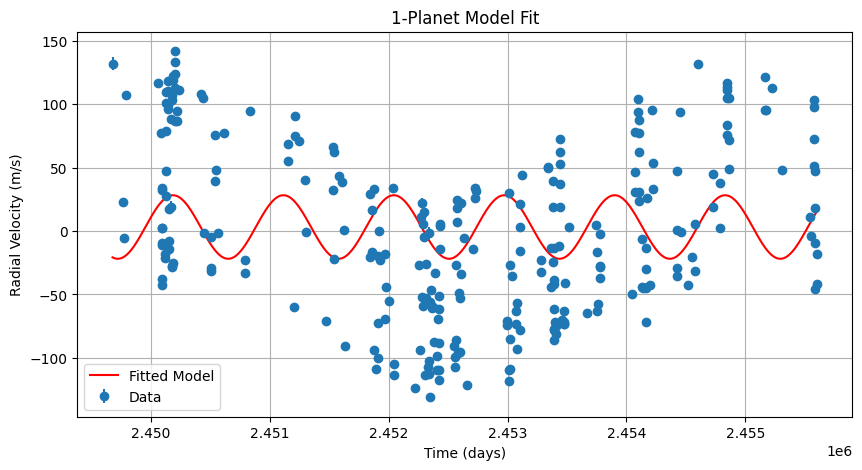

In [4]:
import numpy as np
from scipy.optimize import curve_fit

# Define sinusoidal model
def rv_model(t, K, P, phi, offset):
    return K * np.sin(2 * np.pi * t / P + phi) + offset

# Initial parameter guess
initial_guess = [50, 1000, 0, 0]  # K, P, phi, offset

# Fit the model
params, cov = curve_fit(rv_model, df["time"], df["rv"],
                        sigma=df["uncertainty"],
                        p0=initial_guess,
                        maxfev=10000)
K, P, phi, offset = params

# Generate model values
t_fit = np.linspace(df["time"].min(), df["time"].max(), 1000)
rv_fit = rv_model(t_fit, *params)

# Plot data with model
plt.figure(figsize=(10, 5))
plt.errorbar(df["time"], df["rv"], yerr=df["uncertainty"], fmt='o', label='Data')
plt.plot(t_fit, rv_fit, label='Fitted Model', color='red')
plt.title("1-Planet Model Fit")
plt.xlabel("Time (days)")
plt.ylabel("Radial Velocity (m/s)")
plt.legend()
plt.grid(True)
plt.savefig("fit_1planet.pdf")
plt.show()

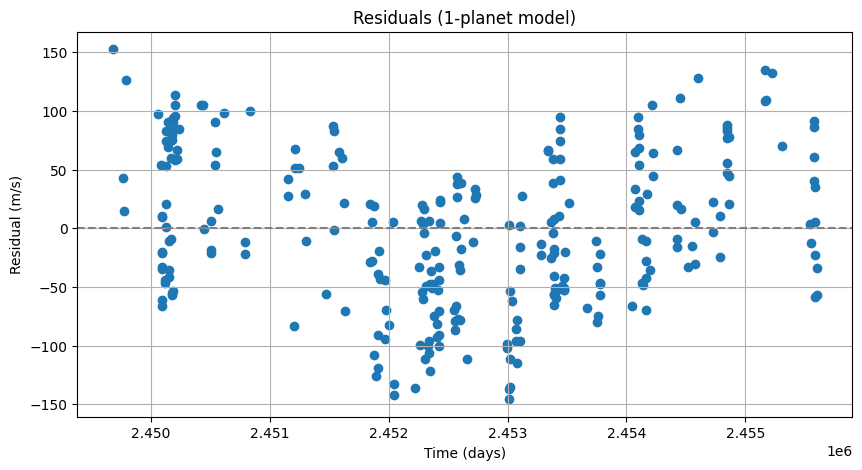

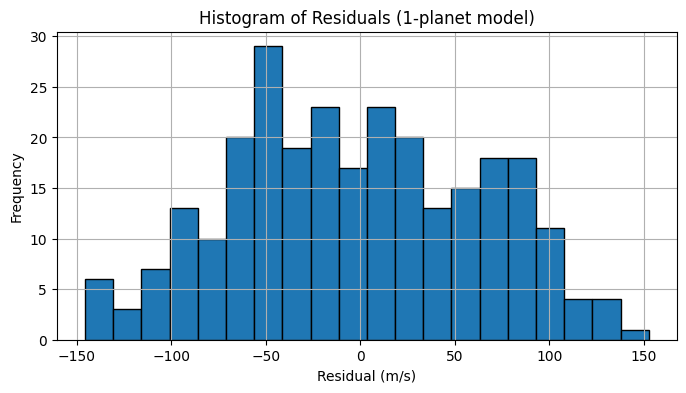

np.float64(64.91168994578814)

In [5]:
residuals = df["rv"] - rv_model(df["time"], *params)

# Residual plot
plt.figure(figsize=(10, 5))
plt.scatter(df["time"], residuals)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals (1-planet model)")
plt.xlabel("Time (days)")
plt.ylabel("Residual (m/s)")
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title("Histogram of Residuals (1-planet model)")
plt.xlabel("Residual (m/s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("hist_1planet.pdf")
plt.show()

# Standard deviation of residuals
std_res = np.std(residuals)
std_res

In [6]:
M_star = 0.905  # 55 Cnc mass in solar masses (example from NASA archive)
M_jupiter = (K / 28.4) * (P / 365)**(1/3) * (M_star)**(2/3)
M_jupiter

np.float64(-1.1254723486341183)

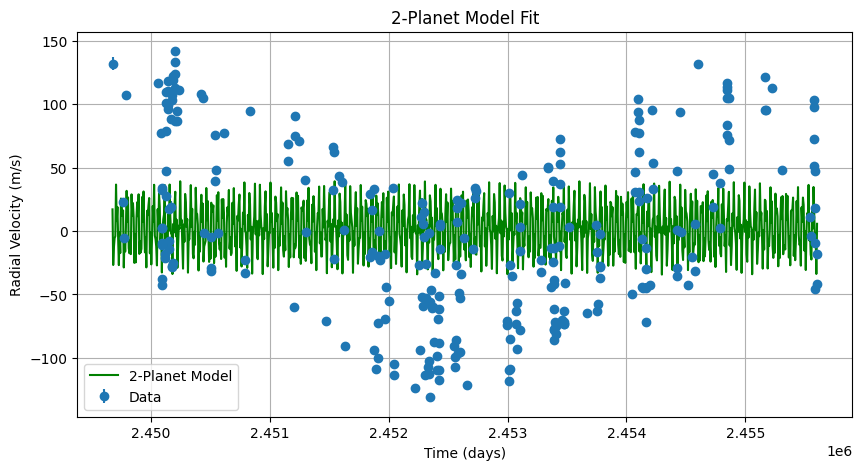

In [11]:
# Optional: Define a two-planet model and refit the curve
def two_planet_model(t, K1, P1, phi1, K2, P2, phi2, offset):
    return (K1 * np.sin(2 * np.pi * t / P1 + phi1) +
            K2 * np.sin(2 * np.pi * t / P2 + phi2) +
            offset)

# Initial guesses for 2 planets
initial_guess_2p = [60, 14.6, 0, 15, 44.3, 0, 0]

# Fit the two-planet model
params_2p, cov_2p = curve_fit(
    two_planet_model,
    df["time"],
    df["rv"],
    sigma=df["uncertainty"],
    p0=initial_guess_2p,
    maxfev=50000  # Increase function evaluations
)

# Generate fit
rv_fit_2p = two_planet_model(t_fit, *params_2p)

# Plot fit
plt.figure(figsize=(10, 5))
plt.errorbar(df["time"], df["rv"], yerr=df["uncertainty"], fmt='o', label='Data')
plt.plot(t_fit, rv_fit_2p, label='2-Planet Model', color='green')
plt.title("2-Planet Model Fit")
plt.xlabel("Time (days)")
plt.ylabel("Radial Velocity (m/s)")
plt.legend()
plt.grid(True)
plt.savefig("fit_2planet.pdf")
plt.show()

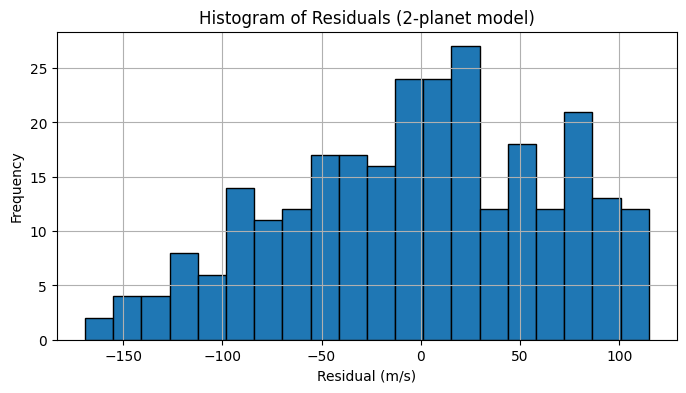

np.float64(66.15642928793667)

In [12]:
residuals_2p = df["rv"] - two_planet_model(df["time"], *params_2p)

plt.figure(figsize=(8, 4))
plt.hist(residuals_2p, bins=20, edgecolor='black')
plt.title("Histogram of Residuals (2-planet model)")
plt.xlabel("Residual (m/s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("hist_2planet.pdf")
plt.show()

# Standard deviation of residuals
np.std(residuals_2p)